In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os



import matplotlib.pyplot as plt

import SMOTE
import feature_selector
import DE
import CFS

import metrices
import measures

import sys
import traceback
import warnings
warnings.filterwarnings("ignore")

In [2]:
def prepare_data(path):
    df = pd.read_csv(path)
    df = df.dropna()
    df = df.astype(np.float64)
    return df

def get_features(df):
    fs = feature_selector.featureSelector()
    df,_feature_nums,features = fs.cfs_bfs(df)
    return df,features

def apply_cfs(df):
    y = df.BUGS.values
    X = df.drop(labels = ['BUGS'],axis = 1)
    X = X.values
    selected_cols = CFS.cfs(X,y)
    cols = df.columns[[selected_cols]].tolist()
    cols.append('BUGS')
    return df[cols],cols
    
def apply_smote(df):
    cols = df.columns
    smt = SMOTE.smote(df)
    df = smt.run()
    df.columns = cols
    return df

def tune_learner(learner, train_X, train_Y, tune_X, tune_Y, goal,target_class=None):
    if not target_class:
        target_class = goal
    clf = learner(train_X, train_Y, tune_X, tune_Y, goal)
    tuner = DE.DE_Tune_ML(clf, clf.get_param(), goal, target_class)
    return tuner.Tune()

In [3]:
class DE_Learners(object):
    def __init__(self, clf, train_X, train_Y, test_X, test_Y, goal):
        """

        :param clf: classifier, SVM, etc...
        :param train_X: training data, independent variables.
        :param train_Y: training labels, dependent variables.
        :param predict_X: testing data, independent variables.
        :param predict_Y: testingd labels, dependent variables.
        :param goal: the objective of your tuning, F, recision,....
        """
        self.train_X = train_X
        self.train_Y = train_Y
        self.test_X = test_X
        self.test_Y = test_Y
        self.goal = goal
        self.param_distribution = self.get_param()
        self.learner = clf
        self.confusion = None
        self.params = None

    def learn(self,F, **kwargs):
        """
        :param F: a dict, holds all scores, can be used during debugging
        :param kwargs: a dict, all the parameters need to set after tuning.
        :return: F, scores.
        """
        self.scores = {self.goal: [0.0]}
        try:    
            self.learner.set_params(**kwargs)
            predict_result = []
            clf = self.learner.fit(self.train_X, self.train_Y)
            predict_result = clf.predict(self.test_X)
            self.abcd = metrices.measures(self.test_Y,predict_result)
            self.scores = self._Abcd(self.abcd,F)
            self.confusion = metrics.classification_report(self.test_Y.values.tolist(), predict_result, digits=2)
            self.params = kwargs
        except Exception as e:
            a = 10
        return self.scores
    
    def _Abcd(self,abcd , F):
        """

        :param predicted: predicted results(labels)
        :param actual: actual results(labels)
        :param F: previously got scores
        :return: updated scores.
        """
        if 'g-score' in self.goal:
            F['g-score'] = [abcd.get_g_score()]
            return F
        elif 'precision' in self.goal:
            F['precision'] = [abcd.get_precision()]
            return F
        elif 'f1' in self.goal:
            F['f1'] = [abcd.calculate_f1_score()]
            return F
        elif 'd2h' in self.goal:
            F['d2h'] = [abcd.calculate_d2h()]
            return F

    def predict(self,test_X):
        return self.learner.predict(test_X)

In [4]:
class SK_LR(DE_Learners):
    def __init__(self, train_x, train_y, predict_x, predict_y, goal):
        clf = LogisticRegression()
        super(SK_LR, self).__init__(clf, train_x, train_y, predict_x, predict_y,goal)

    def get_param(self):
        tunelst = {"penalty": ['l1', 'l2','elasticnet',None],
                   "multi_class": ['ovr', 'multinomial','auto'],
                   "C": [1.0,200.0],
                   "dual": [True, False],
                   "fit_intercept": [True, False],
                   "intercept_scaling": [1.0,100.0],
                   "class_weight": ["balanced", None],
                   "solver": ['newton-cg','lbfgs','liblinear','sag', 'saga'],
                   "warm_start": [True, False],
                   "max_iter": [100,600]}
        return tunelst

In [42]:
path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/datasets/jshint.csv'
df = prepare_data(path)
df.reset_index(drop=True,inplace=True)
y = df.BUGS
X = df.drop(labels = ['BUGS'],axis = 1)
train_X,test_X,train_y,test_y = train_test_split(X, y, test_size=0.33, random_state=13)
df_test = pd.concat([test_X,test_y], axis = 1)
df = pd.concat([train_X,train_y], axis = 1)
df.reset_index(drop=True,inplace=True)
y = df.BUGS
X = df.drop(labels = ['BUGS'],axis = 1)
kf = StratifiedKFold(n_splits = 5)
goal = 'f1'
learner = [SK_LR][0]
F = {}
score = []
for i in range(2):
    for train_index, tune_index in kf.split(X, y):
        X_train, X_tune = X.iloc[train_index], X.iloc[tune_index]
        y_train, y_tune = y[train_index], y[tune_index]
        _df = pd.concat([X_train,y_train], axis = 1)
        _df_tune = pd.concat([X_tune,y_tune], axis = 1)
        _df = apply_smote(_df)
        _df,selected_cols = apply_cfs(_df)
        y_train = _df.BUGS
        X_train = _df.drop(labels = ['BUGS'],axis = 1)
        _df_tune = _df_tune[selected_cols]
        y_tune = _df_tune.BUGS
        X_tune = _df_tune.drop(labels = ['BUGS'],axis = 1)
        _df_test = df_test[selected_cols]
        test_y = _df_test.BUGS
        test_X = _df_test.drop(labels = ['BUGS'],axis = 1)
        params, evaluation = tune_learner(learner, X_train, y_train,  X_tune,y_tune, goal)
        clf = learner(X_train, y_train,  test_X,test_y, goal)
        F = clf.learn(F,**params)
        print(F[goal][0])
        score.append(F[goal][0])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [17]:
score = np.array(score)
np.median(score)

0.6170940170940169

{'whiskers': [<matplotlib.lines.Line2D at 0x1042fa4e0>,
 'caps': [<matplotlib.lines.Line2D at 0x1042fa0f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1042fac88>],
 'medians': [<matplotlib.lines.Line2D at 0x1042f06a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1042f0c18>],
 'means': []}

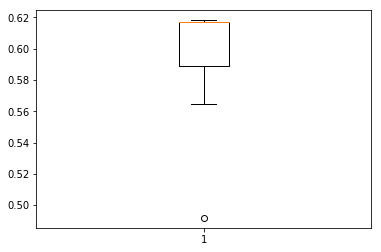

In [18]:
plt.boxplot(score)

In [8]:
project_score_df = pd.DataFrame(project_score, columns=['project','score'])

In [9]:
project_score_df.to_csv('results.csv')

In [31]:
cnt = 0
for i in range(project_score_df.shape[0]):
    if round(np.median(np.array(project_score_df.iloc[i,1])),2) >= .75:
        print(project_score_df.iloc[i,0],round(np.median(np.array(project_score_df.iloc[i,1])),2))
        cnt+=1
print(cnt)
    #print(project_score_df.iloc[i,0],round(np.median(np.array(project_score_df.iloc[i,1])),2))

canal 0.77
zsc 0.86
motogp 1.0
docker 0.82
AndroidSwipeLayout 0.83
FizzBuzzEnterpriseEdition 1.0
recyclerview-animators 0.8
Luban 1.0
Fragmentation 0.76
tetris_project 1.0
10


In [9]:
score

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [45]:
df = pd.read_pickle('data/r2c_hyper.pkl')

gulp-sourcemaps 0.55 0.6
jquery 0.7 0.71
chai-as-promised 0.59 0.61
node-semver 0.41 0.41
coffeescript 0.54 0.62
cheerio 0.71 0.74
underscore 0.67 0.85
eslint-plugin-react 0.87 0.89
gulp-jshint 0.4 0.4
jsdom 0.57 0.59
grunt-contrib-watch 0.37 0.36
generator 0.52 0.57
jshint 0.83 0.93
moment 0.87 0.89
express 0.45 0.46
body-parser 0.35 0.34
node-fs-extra 0.53 0.56
eslint-plugin-import 0.53 0.51


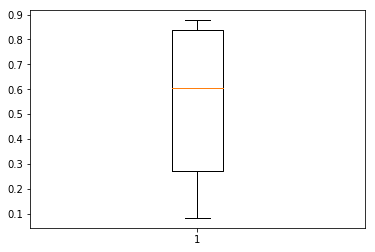

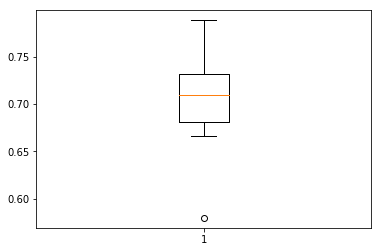

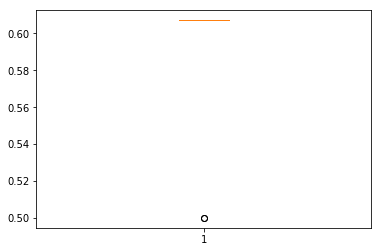

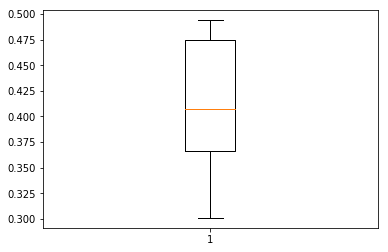

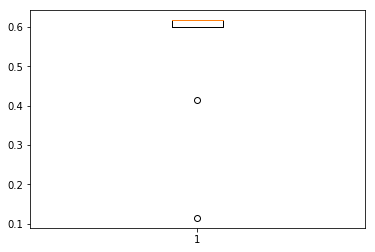

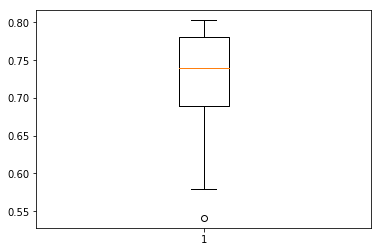

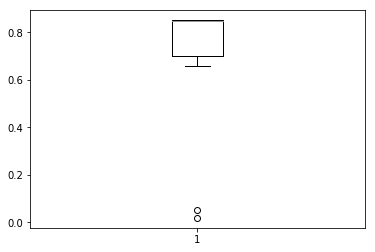

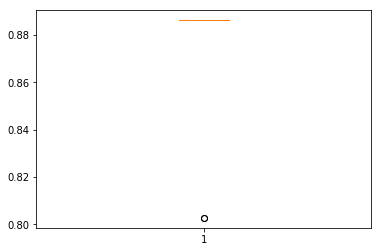

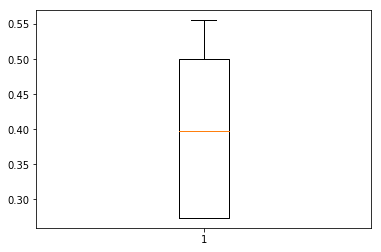

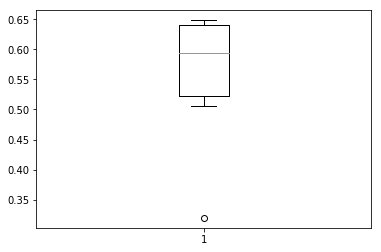

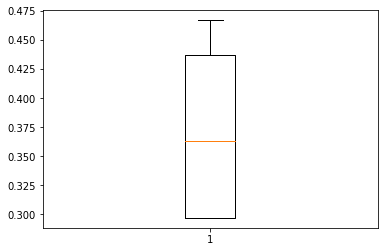

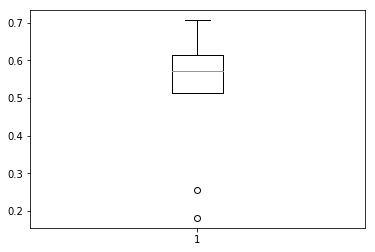

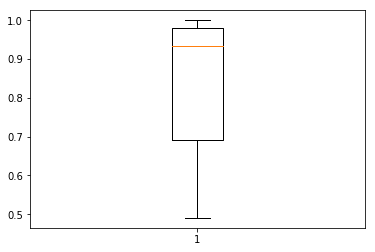

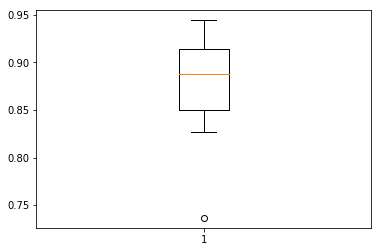

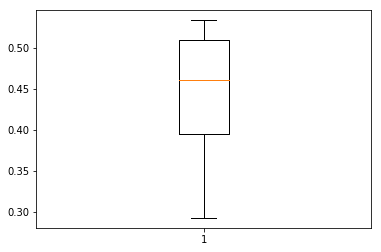

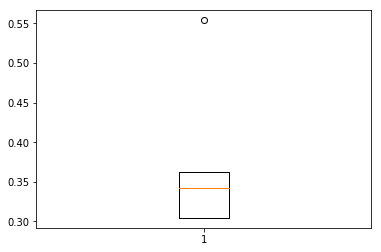

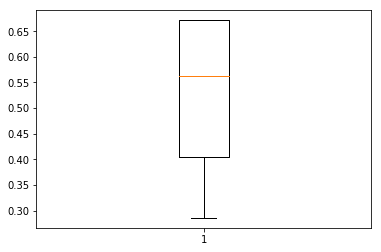

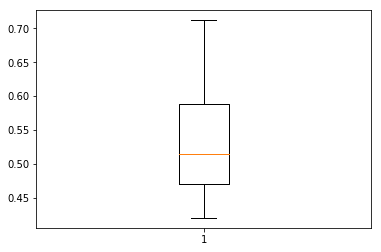

In [48]:
for key in df.keys():
    plt.figure()
    plt.boxplot(df[key])
    print(key,round(np.mean(df[key]),2),round(np.median(df[key]),2))